# Renault car sequencing IV -- lokale Suche

https://www.roadef.org/challenge/2005/en/

Wir importieren ein paar Pakete. (Nicht alle brauchen wir hier.) 
<ul>
    <li><code>numpy</code>: wissenschaftliche Bibliothek, im wesentlichen für die array-Klasse</li>
    <li><code>matplotlib</code>: Visualisierungsfunktionen</li>
    <li><code>math</code>: mathematische Funktionen</li>
</ul>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time

plt.style.use("seaborn")  ## plots sehen so ein bisschen schöner aus

Als nächstes werden die Instanzdaten gelesen und eine Bibliothek (<code>rnlt</code>, kurz für *Renault*) mit Hilfscode (data handling und Visualisierung) importiert. Weiterhin werden die Instanzdaten und <code>rnlt</code> automatisch heruntergeladen -- dies funktioniert so wie es dort steht unter Google Colab und unter Linux (evtl auch iOs). Wenn Sie den Code auf einem Windows-Rechner lokal ausführen wollen, dann laden Sie die Instanzdaten unter (https://www.roadef.org/challenge/2005/files/Instances_set_A.zip)(https://www.roadef.org/challenge/2005/files/Instances_set_A.zip) herunter, dann entpacken Sie die Daten und speichern Sie die Daten und <code>rnlt.py</code> im gleichen Ordner wie dieses juypter-Notebook. Weiterhin müssen Sie die ersten drei Zeilen auskommentieren.

In [2]:
!wget -q https://www.roadef.org/challenge/2005/files/Instances_set_A.zip
!unzip -q Instances_set_A.zip
!wget -q https://raw.githubusercontent.com/henningbruhn/mobp/main/sequencing_aufgabe/rnlt2.py

# Pfad zu den gespeicherten Instanzen -- ersetzen Sie das evtl durch den entsprechenden Pfad bei Ihnen
#path="RENAULT/Instances_set_A/"   
path="Instances/"

import rnlt2 as rnlt

Wir laden wieder alle Instanzen in das dictionary <code>data_dict</code> ein.

In [3]:
data_dict=rnlt.read_in_all_instances(path)

Folgende Instanzen wurden eingelesen: 
  039_38_4_EP_RAF_ch1
  024_38_3_EP_ENP_RAF
  048_39_1_EP_ENP_RAF
  025_38_1_EP_ENP_RAF
  064_38_2_EP_RAF_ENP_ch1
  064_38_2_RAF_EP_ENP_ch2
  022_3_4_EP_RAF_ENP
  048_39_1_EP_RAF_ENP
  024_38_5_EP_RAF_ENP
  039_38_4_RAF_EP_ch1
  024_38_3_EP_RAF_ENP
  025_38_1_EP_RAF_ENP
  064_38_2_EP_RAF_ENP_ch2
  064_38_2_RAF_EP_ENP_ch1
  022_3_4_RAF_EP_ENP
  024_38_5_EP_ENP_RAF


Wir übernehmen ein wenig Code aus dem vorherigen Notebook. Wie zuvor beschaffen wir uns eine Testinstanz, berechnen eine greedy-Lösung und laden auch noch die Renault-Lösung.

In [4]:
def tweak(schedule):
    n=len(schedule)
    first=random.randint(0,n-1)
    second=random.randint(0,n-1)
    swap(schedule,(first,second))
    return [first,second]

def swap(schedule,positions):
    first,second=positions
    schedule[first],schedule[second]=schedule[second],schedule[first]

sample_instance=data_dict['024_38_5_EP_RAF_ENP']
greedy_schedule=rnlt.greedy(sample_instance)
greedy_cost=rnlt.compute_objective(greedy_schedule,sample_instance)
renault_schedule=sample_instance['renault_schedule']
renault_cost=rnlt.compute_objective(renault_schedule,sample_instance)

print("Kosten der greedy-Lösung: {}".format(greedy_cost))

## 5. Aufgabe: Lokale Suche

hill climbing bricht ab, wenn keine Verbesserung mehr gefunden wird. In meiner Implementation werden in jedem Schritt eine Anzahl <code>tries</code> von vielen zufälligen Schritten getestet -- wenn keiner von denen eine Verbesserung erbringt, bricht hill climbing ab. Drei Gründe kann es nun für den Abbruch geben: 1) das Optimum ist gefunden (super! wir sind glücklich), 2) ein lokales Optimum ist erreicht, kein lokaler Schritt kann eine Verbesserung bewirken (hmmm), 3) eine lokale Verbesserung wäre möglich, wurde aber nicht gefunden (uuh). Wie können wir die Szenarien 2) und 3) umgehen? Die Anzahl der Versuche für die lokalen Schritte (der Parameter <code>tries</code>) könnte massiv erhöht werden -- das führt aber dazu, dass der Algorithmus eine hohe Laufzeit hat, da jeder Schritt viel Zeit benötigt. Was kann also getan werden? Und wie kann man einem lokalen Optimum entweichen? Experimentieren Sie!

Algorithmen der lokalen Suche können leicht endlos laufen. Zweckmäßigerweise gibt man ihnen daher ein Zeitbudget: Sie laufen bis die Zeit aufgebraucht ist und dann liefern sie die beste Lösung zurück, die sie im Verlauf besucht haben.

In [ ]:
def local_search(schedule,instance,tries=20,time_budget=60,record_cost=False):
    start_time=time.time()
    best_tracker=rnlt.Best_Tracker()
    current_cost=rnlt.compute_objective(schedule,instance)
    cost_record=[current_cost]
    while time.time()-start_time<time_budget:
        step_tracker=rnlt.Best_Tracker()
        ### Fügen Sie Ihren Code hier ein ###
        ### Ende Einfügung ###
        if record_cost:
            cost_record.append(best_tracker.best_cost)
    if record_cost:
        return best_tracker.best,best_tracker.best_cost,cost_record
    return best_tracker.best,best_tracker.best_cost

time_budget=60
new_schedule,cost,cost_record=down_if_no_way_up(greedy_schedule.copy(),sample_instance,time_budget=time_budget,tries=50,record_cost=True)
rnlt.check_for_completeness(new_schedule,sample_instance)
down_cost=rnlt.compute_objective(new_schedule,sample_instance)

print("Kosten local search: {}".format(down_cost))
print("Kosten Renault     : {}".format(renault_cost))
print("Zeitbudget         : {}s".format(time_budget))

In [13]:
def down_if_no_way_up(schedule,instance,tries=20,time_budget=60,record_cost=False):
    start_time=time.time()
    best_tracker=rnlt.Best_Tracker()
    current_cost=rnlt.compute_objective(schedule,instance)
    cost_record=[current_cost]
    while time.time()-start_time<time_budget:
        step_tracker=rnlt.Best_Tracker()
        for _ in range(tries):
            positions=tweak(schedule)
            cost=rnlt.compute_objective(schedule,instance)
            step_tracker.update(positions,cost)
            swap(schedule,positions)
        positions=step_tracker.best   ## accept even if it's worse than previous solution
        swap(schedule,positions)
        current_cost=step_tracker.best_cost
        best_tracker.update(schedule,current_cost)
        if record_cost:
            cost_record.append(best_tracker.best_cost)
            
    if record_cost:
        return best_tracker.best,best_tracker.best_cost,cost_record
    return best_tracker.best,best_tracker.best_cost

time_budget=60
new_schedule,cost,cost_record=down_if_no_way_up(greedy_schedule.copy(),sample_instance,time_budget=time_budget,tries=50,record_cost=True)
rnlt.check_for_completeness(new_schedule,sample_instance)
down_cost=rnlt.compute_objective(new_schedule,sample_instance)

print("Kosten local search: {}".format(down_cost))
print("Kosten Renault     : {}".format(renault_cost))
print("Zeitbudget         : {}s".format(time_budget))

Reihung vollständig!
Kosten local search: 153627461.0
Kosten Renault     : 96467092.0
Zeitbudget         : 60s


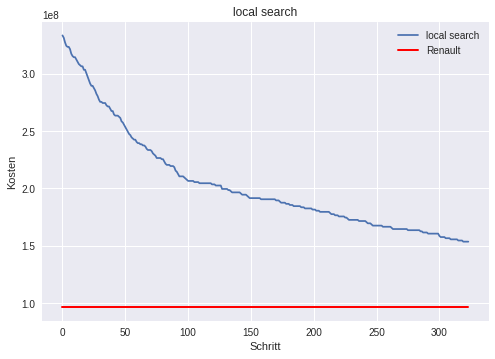

In [14]:
plt.plot(cost_record,label="local search")
plt.xlabel("Schritt")
plt.ylabel("Kosten")
plt.plot([renault_cost]*len(cost_record),"r",linewidth=2,label="Renault")
plt.title("local search")
plt.legend()

In [ ]:
plot_options_and_colours(new_schedule,sample_instance)

In [18]:
def accept_first(schedule,instance,tries=20,time_budget=60,record_cost=False):
    start_time=time.time()
    best_tracker=rnlt.Best_Tracker()
    current_cost=rnlt.compute_objective(schedule,instance)
    cost_record=[current_cost]
    while time.time()-start_time<time_budget:
        step_tracker=rnlt.Best_Tracker()
        for _ in range(tries):
            positions=tweak(schedule)
            cost=rnlt.compute_objective(schedule,instance)
            step_tracker.update(positions,cost)
            if best_tracker.update(schedule,cost):
                break
            swap(schedule,positions)
        positions=step_tracker.best   ## accept even if it's worse than previous solution
        swap(schedule,positions)
        current_cost=step_tracker.best_cost
        if record_cost:
            cost_record.append(best_tracker.best_cost)
            
    if record_cost:
        return best_tracker.best,best_tracker.best_cost,cost_record
    return best_tracker.best,best_tracker.best_cost

time_budget=60
new_schedule,cost,cost_record=accept_first(greedy_schedule.copy(),sample_instance,time_budget=time_budget,tries=50,record_cost=True)
rnlt.check_for_completeness(new_schedule,sample_instance)
acc_cost=rnlt.compute_objective(new_schedule,sample_instance)

print("Kosten local search: {}".format(acc_cost))
print("Kosten Renault     : {}".format(renault_cost))
print("Zeitbudget         : {}s".format(time_budget))

Reihung vollständig!
Kosten local search: 205595505.0
Kosten Renault     : 96467092.0
Zeitbudget         : 60s


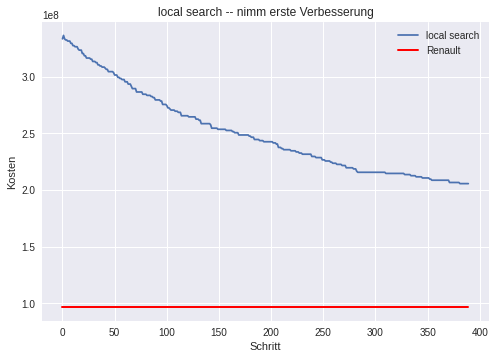

In [19]:
plt.plot(cost_record,label="local search")
plt.xlabel("Schritt")
plt.ylabel("Kosten")
plt.plot([renault_cost]*len(cost_record),"r",linewidth=2,label="Renault")
plt.title("local search -- nimm erste Verbesserung")
plt.legend()